In [3]:
from math import sqrt
import numpy as np
import torch
from torch import nn
import torchani
import pyanitools as pya
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# device to run the training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CHEM 277B - Final Project #

## Machine Learning-Based Energy Prediction for Molecular Systems: Modeling and Analysis using ANI-1 Dataset ##

## Joshua Blomgren ##

For this project, we will develop a supervised learning artificial neural network (ANN) that predicts the energy of a molecular system given the coordinates of the molecules in the system. While solving the Schrodinger equation is computationally expensive, we will be using machine learning to predict the system's energy without solving the equation computationally. 

## Data Processing: Understanding the ANI-1 Dataset ##

The ANI-1 dataset is a collection of 57,000 organic molecules with up to 8 heavy atoms. Let's look at the first subset of the dataset involving only one heavy atom. 

In [4]:
# Load ANI-1 dataset with 1 heavy atom
ani_data = pya.anidataloader(
    '/global/scratch/users/joshuablomgren/ANI-1_release/ani_gdb_s01.h5')

# Loop over each data point in the dataset
for data in ani_data:
    # Extract information from the dataset
    path = data['path']
    coordinates = data['coordinates']
    energies = data['energies']
    species = data['species']
    smiles = data['smiles']

    # Print the information for this data point
    print("Path:      ", path)
    print("  SMILES:  ", "".join(smiles))
    print("  Symbols: ", species)
    print("  Coordinates: ", coordinates.shape)
    print("  Energies:    ", energies.shape, "\n")

# Close the H5 data file
ani_data.cleanup()

Path:       /gdb11_s01/gdb11_s01-0
  SMILES:   [H]C([H])([H])[H]
  Symbols:  ['C', 'H', 'H', 'H', 'H']
  Coordinates:  (5400, 5, 3)
  Energies:     (5400,) 

Path:       /gdb11_s01/gdb11_s01-1
  SMILES:   [H]N([H])[H]
  Symbols:  ['N', 'H', 'H', 'H']
  Coordinates:  (3600, 4, 3)
  Energies:     (3600,) 

Path:       /gdb11_s01/gdb11_s01-2
  SMILES:   [H]O[H]
  Symbols:  ['O', 'H', 'H']
  Coordinates:  (1800, 3, 3)
  Energies:     (1800,) 



The coordinates indicate that each molecule contains several thousand conformations, with the coordinates of each molecule represented by a 3-dimensional array of shape (num_confirmations, num_atoms, 3 dimensions). The energies correspond to each conformation, resulting in the size of the energies array being equal to the number of confirmations.

### Subsets 1-4 of ANI-1 Dataset ###

In [5]:
# Files s01-s04
h5files = ['/global/scratch/users/joshuablomgren/ANI-1_release/ani_gdb_s0%d.h5' % 
           i for i in range(1, 5)]

count = 0
count_conformations = 0

# Iterate through the specified subset files
for h5file in h5files:
    # Load the data from the subset file
    data = pya.anidataloader(h5file)
    data_iter = data.__iter__()

    # Iterate through all the molecules in the subset file
    for mol in data_iter:
        count += 1
        count_conformations += len(mol['energies'])

print(count)
print(count_conformations)

97
864898


Across ANI-1 subsets 1 to 4, there are **97** molecules altogether, totaling **864,898** conformations. The number of conformations varies for each molecule.

<br>

## Data Processing: Atomic Environment Vectors (AEVs) ##

AEVs, Atomic Environment Vectors, are feature vectors that encode the local chemical environment around an atom in a molecule. We will be using AEVs to transform the initial atomic configurations using symmetry functions before putting them in our neural network. In order to train a neural network for predicting molecular properties, it is important to ensure that the network is invariant to translations, rotations, and permutations of the atoms in a molecule, which can be achieved through computing AEVs. 

The `torchani` library provides a module called AEV Computer that computes the AEVs (Atomic Environment Vectors) of molecular structures. The `torchani.AEVComputer` class is initialized with certain parameters such as Rcr (cutoff radius for radial symmetry functions), Rca (cutoff radius for angular symmetry functions), and a set of hyperparameters such as EtaR, EtaA, Zeta, ShfR, ShfA, and ShfZ, which are used to compute the AEVs of molecular structures.

In [6]:
data = pya.anidataloader('/global/scratch/users/joshuablomgren/ANI-1_release/ani_gdb_s01.h5')
data_iter = data.__iter__()
mols = next(data_iter)
# Extract the data
P = mols['path']
X = mols['coordinates']
E = mols['energies']
S = mols['species']
sm = mols['smiles']

Rcr = 5.2
EtaR = torch.tensor([16], dtype=torch.float)
ShfR = torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,
                     2.243750,2.51250,2.781250,3.050000,3.318750,3.587500,
                     3.856250,4.125000,4.39375,4.662500,4.931250])
Rca = 3.5
EtaA = torch.tensor([8], dtype=torch.float)
ShfA = torch.tensor([0.900000,1.550000,2.200000,2.850000], dtype=torch.float)
ShfZ = torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,
                     1.7671459,2.1598449,2.552544,2.945243]) 
Zeta = torch.tensor([32], dtype=torch.float)
species_order = ['H', 'C', 'N', 'O']
num_species = len(species_order)

aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, 
                                    Zeta, ShfA, ShfZ, num_species)

mapping = {"H": 0, "C": 1, "N": 2, "O": 3} # map atom types to integers
species = np.array([mapping[atom] for atom in S]) #S the same S as symbols
species = np.tile(species, (X.shape[0], 1)) 
species = torch.tensor(species)
X = torch.tensor(X)

aevs = aev_computer((species, X))[1]
aevs.shape

torch.Size([5400, 5, 384])

The `AEVComputer` returns a SpeciesAEV object that contains the mapped atomic symbols as well as the AEVs for each atom. 384 AEVs are generated for each atom in a molecule. In the case for this methane molecule, there are 384 AEV vectors for each of the 5 atoms in methane (C-H-H-H-H) over 5400 conformations.

## Model: Neural Network ##

### Vanilla Neural Network ###

In [7]:
class ANI_Model(nn.Module):
    """
    Neural Network model that predicts molecular energy based on 
    atom types and AEVs. The AEVs of specific atom types are propagated 
    into their corresponding networks. 
    """
    def __init__(self, architecture):
        super().__init__()
        self.sub_nets = nn.ModuleDict({
            'H': ANI_sub(architecture[0]),
            'C': ANI_sub(architecture[1]),
            'N': ANI_sub(architecture[2]),
            'O': ANI_sub(architecture[3])
        })
        
    def forward(self, species_aevs):
        atomic_energies = self.mask_aevs(species_aevs)
        return torch.sum(atomic_energies, dim=1)
    
    def mask_aevs(self, species_aevs):
        """
        Masks the species by the atom type so that the correct atom AEVs go into the
        correct subnetwork.
        """
        species, aevs = species_aevs
    
        # Flatten tensors
        species_1d = species.flatten()
        aevs = aevs.flatten(0, 1)

        # Initialize energies tensor with -1 (size: batch size)
        aevs_shape = aevs.shape
        energies = torch.empty(aevs_shape[0], dtype=aevs.dtype, 
                              device=aevs.device).fill_(-1)
        
        # Mapping from integer atom type to atom symbol
        atom_symbol_map = {'H': 0, 'C': 1, 'N': 2, 'O': 3}

        # Iterate through each ANI_sub network
        for atom_symbol, net in self.sub_nets.items():
            atom_type = atom_symbol_map[atom_symbol] # convert from atom symbol to int
            mask = (species_1d == atom_type)         # boolean mask for desired atoms
            atom_indices = torch.where(mask)[0]      # get the indices of desired atoms

            # Ignore if there are no atoms of an atom type
            if atom_indices.shape[0] > 0:
                masked_aevs = aevs[atom_indices].to(aevs.device)
                energies[mask] = net(masked_aevs).flatten()  # input aevs to sub network

        # undo flattening
        energies = energies.reshape(species.shape) 
        return energies
    
class ANI_sub(nn.Module):
    """
    Sub networks of ANI_Model that take in AEVs of a specific atom type and
    outputs predicted atomic energies of the atom type.
    """
    def __init__(self, architecture):
        super().__init__()
        self.architecture = architecture
        
    def forward(self, aev):
        atomic_energy = self.architecture(aev)
        return atomic_energy

In [8]:
architecture = [
    # H network
    torch.nn.Sequential(
        torch.nn.Linear(384, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 1)
    ),
    # C network
    torch.nn.Sequential(
        torch.nn.Linear(384, 192),
        torch.nn.ReLU(),
        torch.nn.Linear(192, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 1)
    ),
    # N network
    torch.nn.Sequential(
        torch.nn.Linear(384, 160),
        torch.nn.ReLU(),
        torch.nn.Linear(160, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 1)
    ),
    # O network
    torch.nn.Sequential(
        torch.nn.Linear(384, 160),
        torch.nn.ReLU(),
        torch.nn.Linear(160, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 1)
    )
]


model = ANI_Model(architecture)

In [9]:
print(model)

ANI_Model(
  (sub_nets): ModuleDict(
    (H): ANI_sub(
      (architecture): Sequential(
        (0): Linear(in_features=384, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=64, bias=True)
        (5): ReLU()
        (6): Linear(in_features=64, out_features=1, bias=True)
      )
    )
    (C): ANI_sub(
      (architecture): Sequential(
        (0): Linear(in_features=384, out_features=192, bias=True)
        (1): ReLU()
        (2): Linear(in_features=192, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=64, bias=True)
        (5): ReLU()
        (6): Linear(in_features=64, out_features=1, bias=True)
      )
    )
    (N): ANI_sub(
      (architecture): Sequential(
        (0): Linear(in_features=384, out_features=160, bias=True)
        (1): ReLU()
        (2): Linear(in_features=160, out_features=128

## Training ##

The following SpeciesAEVsEnergy class is a custom dataset that holds the species information, AEVs, and energy values all together to make batching the data simpler.

In [10]:
from torch.utils.data import Dataset, DataLoader

class SpeciesAEVsEnergy(Dataset):
    """
    Custom dataset for species, AEVs, and energies.
    """
    def __init__(self, species, aevs, E):
        self.species = species
        self.aevs = aevs
        self.E = E

    def __len__(self):
        """
        Returns length of the dataset
        """
        return len(self.species)

    def __getitem__(self, idx):
        """
        Returns a tuple of species, AEVs, and energies at a given index
        """
        return self.species[idx], self.aevs[idx], self.E[idx]

In [11]:
# AEV Computer hyperparameters
Rcr = 5.2
EtaR = torch.tensor([16], dtype=torch.float)
ShfR = torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,
                     2.243750,2.51250,2.781250,3.050000,3.318750,
                     3.587500,3.856250,4.125000,4.39375,4.662500,4.931250])
Rca = 3.5
EtaA = torch.tensor([8], dtype=torch.float)
ShfA = torch.tensor([0.900000,1.550000,2.200000,2.850000], dtype=torch.float)
ShfZ = torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,
                     1.7671459,2.1598449,2.552544,2.945243]) 
Zeta = torch.tensor([32], dtype=torch.float)

species_order = ['H', 'C', 'N', 'O']
num_species = len(species_order) # number of different atom symbols

aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, 
                                    Zeta, ShfA, ShfZ, num_species)

In [34]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epochs, batch_size):
        """
        A class that trains the ANI model.

        Parameters
        ----------
        model : ANI_Model
            The model to be trained.
        optimizer_type : str
            The type of optimizer to use. Either 'sgd' or 'adam'.
        learning_rate : float
            The learning rate of the optimizer.
        epochs : int
            The number of epochs to train the model for.
        batch_size : int
            The batch size to use for training.
        """
        self.model = model
        if optimizer_type == 'sgd':
            self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        elif optimizer_type == 'adam':
            self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        self.epochs = epochs
        self.batch_size = batch_size
        self.mse = torch.nn.MSELoss()

        # Send to GPU device
        self.model.to(device)

    @timing
    def train(self, num_heavy_atoms, l2=False):
        """
        Trains the model with the given parameters.

        Parameters
        ----------
        num_heavy_atoms : int
            The number of heavy atoms to train the model on (1-8).
        l2 : bool
            Whether or not to use L2 regularization.
        """
        # Iterate through the subsets of ANI dataset
        h5files = ['/global/scratch/users/joshuablomgren/ANI-1_release/ani_gdb_s0%d.h5' % 
        i for i in range(1, num_heavy_atoms + 1)]
        
        losses = []
        val_losses = []

        for i in range(self.epochs):
            epoch_losses = []
            epoch_val_losses = []
            for d in h5files:
                for mol in pya.anidataloader(d):
                    # Extract the data
                    S = mol['species']
                    X = mol['coordinates']
                    E = mol['energies']
                    
                    # Convert to PyTorch tensors and translate species to integers
                    species = np.array([mapping[atom] for atom in S])  
                    species = np.tile(species, (X.shape[0], 1)) 
                    species = torch.tensor(species)
                    X = torch.tensor(X)

                    # Compute AEVs
                    species, aevs = aev_computer((species, X))

                    # Split into training and validation sets
                    species_train, species_test, \
                    aevs_train, aevs_test, \
                    E_train, E_test = train_test_split(species, aevs, E, test_size=0.2, random_state=42)

                    # Move the training and val data to the GPU
                    species_train = species_train.to(device)
                    species_test = species_test.to(device)
                    aevs_train = aevs_train.to(device)
                    aevs_test = aevs_test.to(device)
                    E_train = torch.tensor(E_train).to(device)
                    E_test = torch.tensor(E_test).to(device)

                    # Create the datasets for training and validation
                    train_dataset = SpeciesAEVsEnergy(species_train, aevs_train, E_train)
                    val_dataset = SpeciesAEVsEnergy(species_test, aevs_test, E_test)

                    # Create a DataLoader for the training and validation sets
                    train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
                    val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)

                    # Train the model
                    self.model.train()
                    molecule_loss = 0.0
    
                    for batch in train_dataloader:
                        species_batch, aevs_batch, E_batch = batch
                        species_batch = species_batch.to(device)
                        aevs_batch = aevs_batch.to(device)
                        E_batch = E_batch.to(device)

                        batch_importance = len(species_batch) / len(species_train)
            
                        E_pred = self.model((species_batch, aevs_batch)).double().to(device)
                        loss = self.mse(E_pred, E_batch.double())
                    
                        if l2:
                            ### Compute the loss with L2 regularization ###
                            l2_lambda = 1e-5
                            l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                            loss = loss + l2_lambda * l2_norm
                        # Backpropagate and update the weights
                        self.optimizer.zero_grad()
                        loss.backward()
                        self.optimizer.step()
                        molecule_loss += loss.item() * batch_importance
                    
                    # average loss for all batches
                    epoch_losses.append(molecule_loss)
                    
                    # Evaluate the model
                    val_loss = self.evaluate(val_dataset)
                    epoch_val_losses.append(val_loss)
                
                # Close the H5 data file
                pya.anidataloader(d).cleanup()

            
            # Calculate the average losses for epoch
            epoch_train_loss = np.mean(epoch_losses)
            epoch_train_loss = sqrt(epoch_train_loss)
            epoch_train_loss = epoch_train_loss * 627.509  # Conversion factor: Hartree to kcal/mol
            epoch_val_loss = np.mean(epoch_val_losses)
            epoch_val_loss = sqrt(epoch_val_loss)
            epoch_val_loss = epoch_val_loss * 627.509
            
            # Append the average training and validation loss
            losses.append(epoch_train_loss)
            val_losses.append(epoch_val_loss)

            
            if i % 10 == 0:
                print('Epoch: %d, Training Loss: %f kcal/mol, Validation Loss: %f' % 
                      (i, epoch_train_loss, epoch_val_loss))
    
        
        return self.model, {'loss': losses, 'val_loss': val_losses}
                    
    
    def evaluate(self, dataset):
        """
        Evaluates the model on the given inputs and outputs.

        Parameters
        ----------
        inputs : SpeciesAEVsEnergy
            A custom dataset containing species, AEVs, and energies.
        outputs : torch.Tensor
            A tensor of energies.

        Returns
        -------
        float
            The mean squared error of the model.
        """
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        losses = 0

        for batch in test_dataloader:
            batch_importance = len(batch[0]) / len(dataset)
            species_batch, aevs_batch, E_batch = batch
            species_batch = species_batch.to(device)
            aevs_batch = aevs_batch.to(device)
            E_batch = E_batch.to(device)

            with torch.no_grad():
                E_pred = self.model((species_batch, aevs_batch))
                loss = self.mse(E_pred, E_batch)
            losses += loss.item() * batch_importance 
        
        return losses

## Training Results ##

In [35]:
trainer = Trainer(model, 'sgd', 1e-3, 100, 600)
trained_model, log = trainer.train(4, l2='True')

Epoch: 0, Training Loss: 13263.806933 kcal/mol, Validation Loss: 10432.899929
Epoch: 10, Training Loss: 939.735368 kcal/mol, Validation Loss: 1353.985346
Epoch: 20, Training Loss: 477.147842 kcal/mol, Validation Loss: 106.332141
Epoch: 30, Training Loss: 474.235706 kcal/mol, Validation Loss: 57.354576
Epoch: 40, Training Loss: 474.150304 kcal/mol, Validation Loss: 54.139822
Epoch: 50, Training Loss: 474.165271 kcal/mol, Validation Loss: 54.839105
Epoch: 60, Training Loss: 474.148763 kcal/mol, Validation Loss: 53.891853
Epoch: 70, Training Loss: 474.164680 kcal/mol, Validation Loss: 54.661827
Epoch: 80, Training Loss: 474.189599 kcal/mol, Validation Loss: 55.784409
Epoch: 90, Training Loss: 474.166105 kcal/mol, Validation Loss: 54.877402
func:'train'  took: 12250.2732 sec


The training and validation losses printed above are the average training and validation losses per epoch, including the confirmations of all the molecules in all of the 4 ANI-1 subsets. 

**After 100 epochs, the lowest training error is 474.148763 kcal/mol at epoch 60, and the lowest validation error is 53.891853 kcal/mol at epoch 60.**

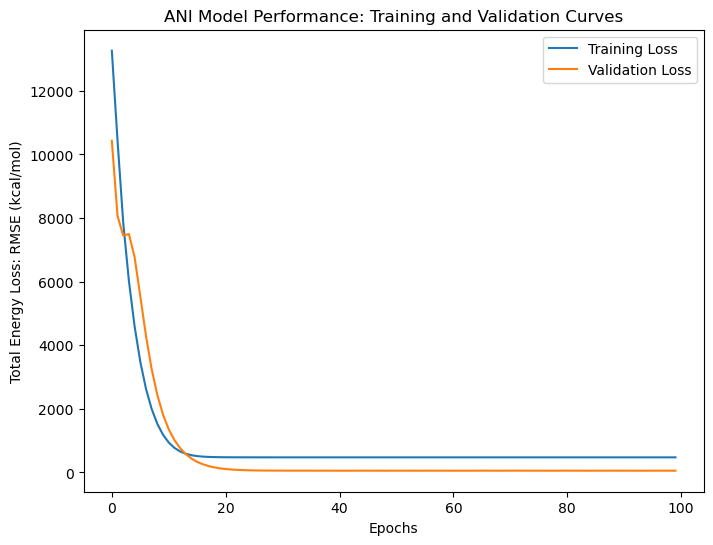

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(log['loss'], label='Training Loss')
plt.plot(log['val_loss'], label='Validation Loss')
plt.title('ANI Model Performance: Training and Validation Curves')
plt.xlabel('Epochs')
plt.ylabel('Total Energy Loss: RMSE (kcal/mol)')
plt.legend()
plt.show()